# Inférence & eval

In [1]:
import torch
import numpy as np
thresholds   = [0.1, 1, 2.5]  # series of thresholds (unit: mm/h)
thresholds   = [100*k/12 for k in thresholds]
scores_rain = torch.load('lastrun-m1-rain/scores.pt')
scores_wind = torch.load('lastrun-m1-wind/scores.pt')

In [2]:
print(list(np.array(scores_rain['val_f1_pred']).max(axis=0)))
print(list(np.array(scores_wind['val_f1_pred']).max(axis=0)))

[0.7052562, 0.5836889, 0.41793805]
[0.7027007, 0.592567, 0.45359907]


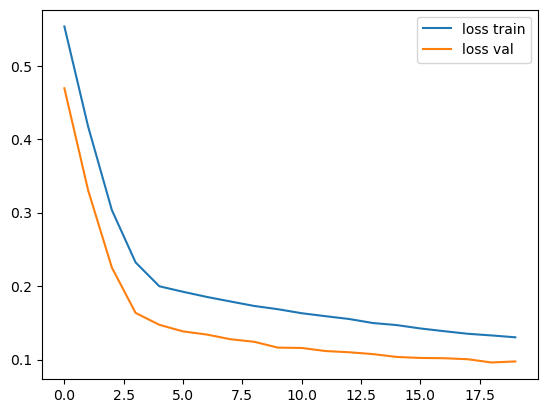

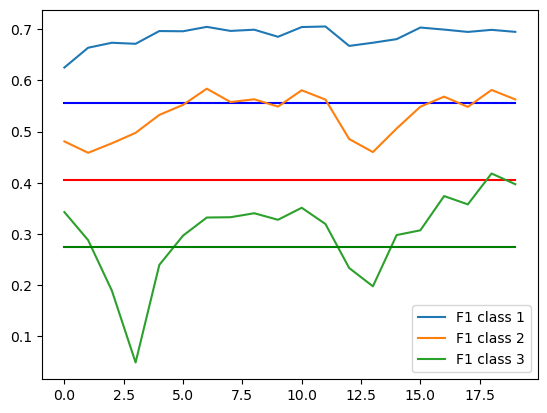

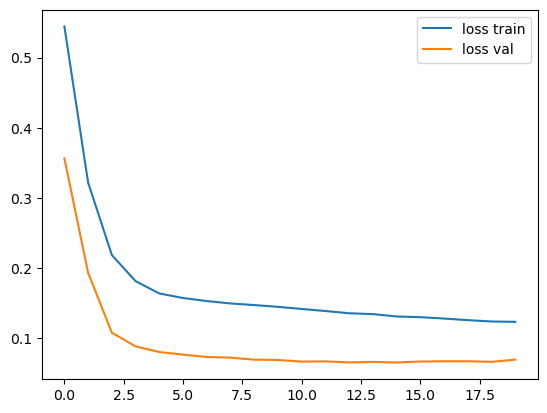

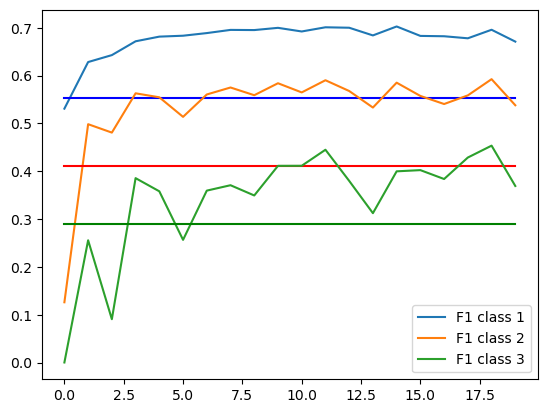

In [3]:
import matplotlib.pyplot as plt

def plot_scores( scores, save=None):
    plt.plot(scores['train_losses'], label='loss train')
    plt.plot(scores['val_losses'], label='loss val')
    plt.legend()
    plt.show()
    sc = scores['val_f1_pred']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='F1 class 1')
    plt.plot([scores['f1_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='F1 class 2')
    plt.plot([scores['f1_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='F1 class 3')
    plt.plot([scores['f1_pers'][2]]*l,'g')
    plt.legend()
    if save:
        plt.savefig(save)
    else:
        plt.show()
plot_scores(scores_rain)
plot_scores(scores_wind)


In [4]:
# get train, val and test datasets
from loader.meteonet import MeteonetDataset
from tqdm import tqdm
from loader.filesets import filesets_bouget21

train_files, val_files, test_files = filesets_bouget21('data/rainmaps')

# datasets rainmaps and windmaps
train_ds = MeteonetDataset( train_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/train-wind.npz', tqdm=tqdm)
val_ds   = MeteonetDataset( val_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/val-wind.npz', tqdm=tqdm)
test_ds  = MeteonetDataset( test_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/test-wind.npz', tqdm=tqdm)

# dataset only rainmaps
rain_val_ds = MeteonetDataset( val_files, 12, 18, 12, cached=f'data/val.npz', tqdm=tqdm)
rain_test_ds = MeteonetDataset( test_files, 12, 18, 12, cached=f'data/test.npz', tqdm=tqdm)

# important!
val_ds.norm_factor = train_ds.norm_factor
test_ds.norm_factor = train_ds.norm_factor
rain_val_ds.norm_factor = train_ds.norm_factor
rain_test_ds.norm_factor = train_ds.norm_factor

val_ds.params['U_moments'] = train_ds.params['U_moments']
val_ds.params['V_moments'] = train_ds.params['V_moments']

test_ds.params['U_moments'] = train_ds.params['U_moments']
test_ds.params['V_moments'] = train_ds.params['V_moments']


In [5]:
from torch.utils.data import DataLoader
from loader.samplers import meteonet_sequential_sampler
test_sampler = meteonet_sequential_sampler( test_ds)
test_loader = DataLoader(test_ds, batch_size=64, sampler=test_sampler ) 
rain_test_sampler = meteonet_sequential_sampler( rain_test_ds)
rain_test_loader = DataLoader(rain_test_ds, batch_size=64, sampler=rain_test_sampler ) 

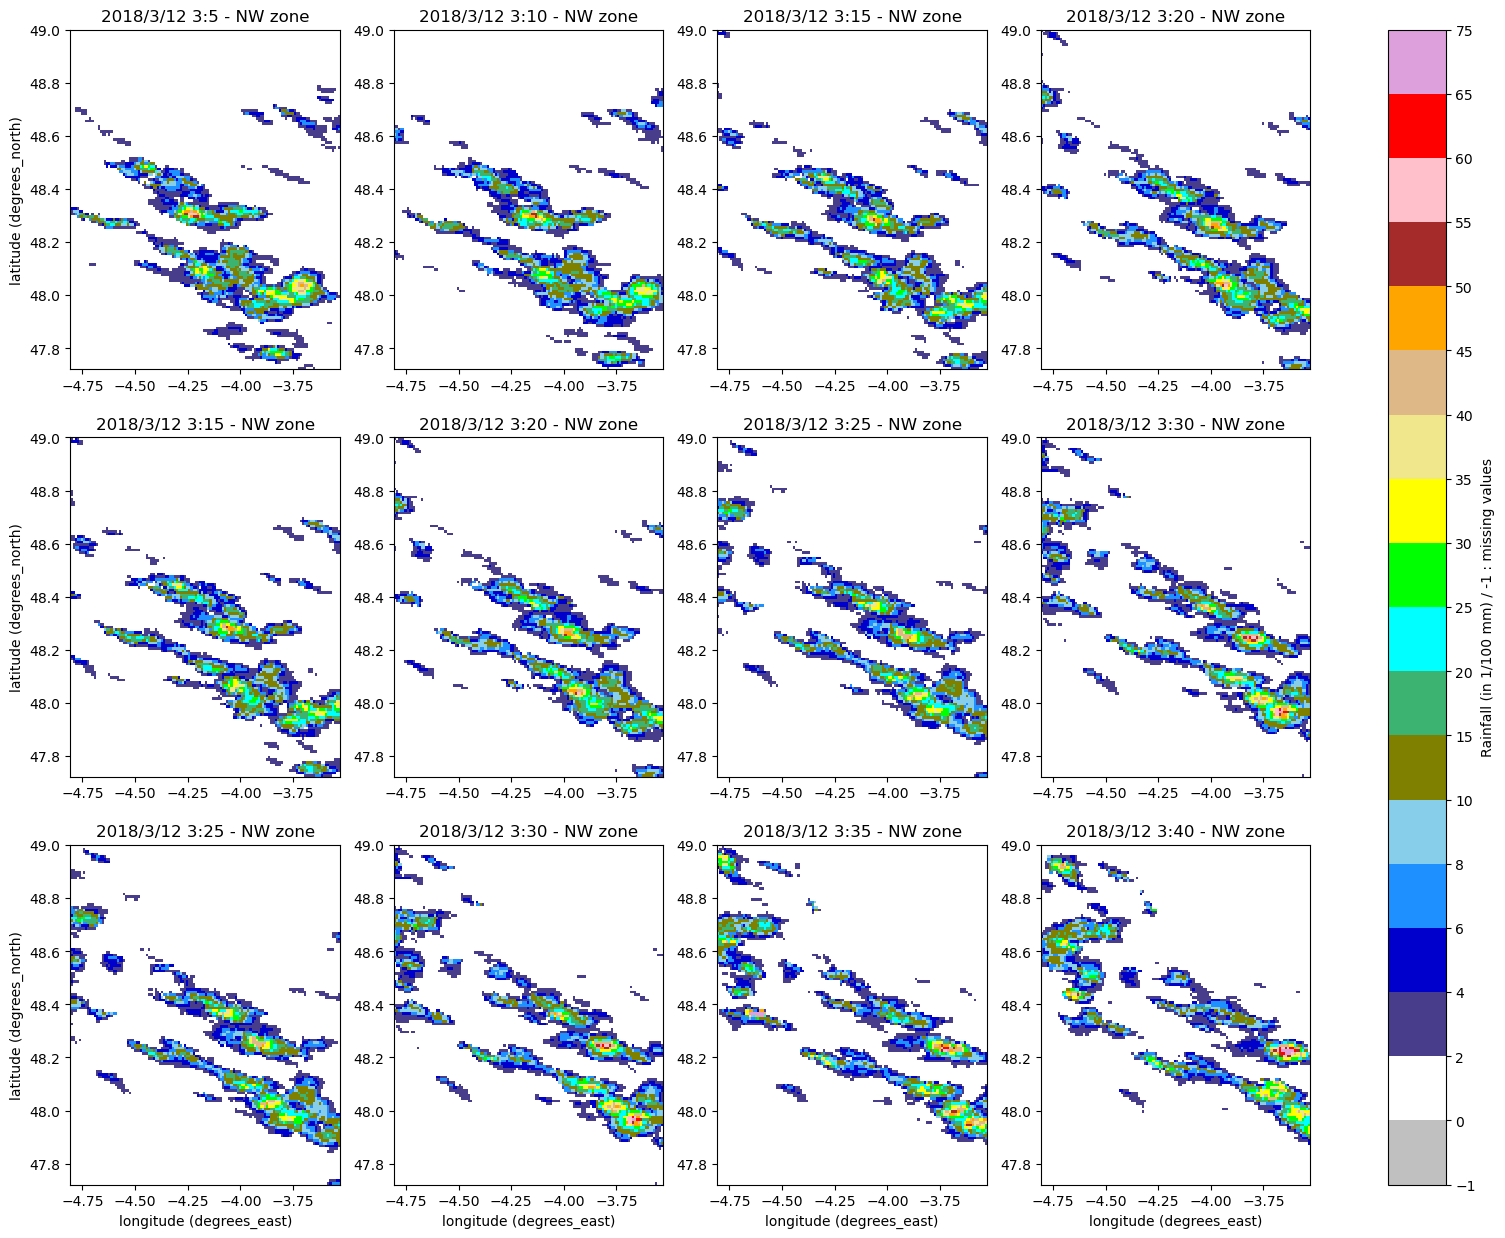

In [8]:
from loader.plots import plot_meteonet_rainmaps
from data.constants import *
import numpy as np

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

train_date = 2017,3,1,12,0 # dans train_ds
val_date = 2018,3,12,3,5 # dans val_ds

plot_meteonet_rainmaps( val_ds, val_date, lon, lat, zone, n=4)

In [7]:
from models.unet import UNet

# three models
model_dom_rain = UNet( n_channels= 12, n_classes = 3, bilinear = True)
model_dom_rain.load_state_dict(torch.load('weights/model_dom_30m_rain.pt',  map_location=torch.device('cpu')))

model_dom = UNet( n_channels= 12*3, n_classes = 3, bilinear = True)
model_dom.load_state_dict(torch.load('weights/model_dom_30m_wind.pt',  map_location=torch.device('cpu')))

model_vinc = UNet( n_channels= 12*3, n_classes = 3, bilinear = True)
model_vinc.load_state_dict(torch.load('weights/model_vinc_30m_wind.pt',  map_location=torch.device('cpu')))

<All keys matched successfully>

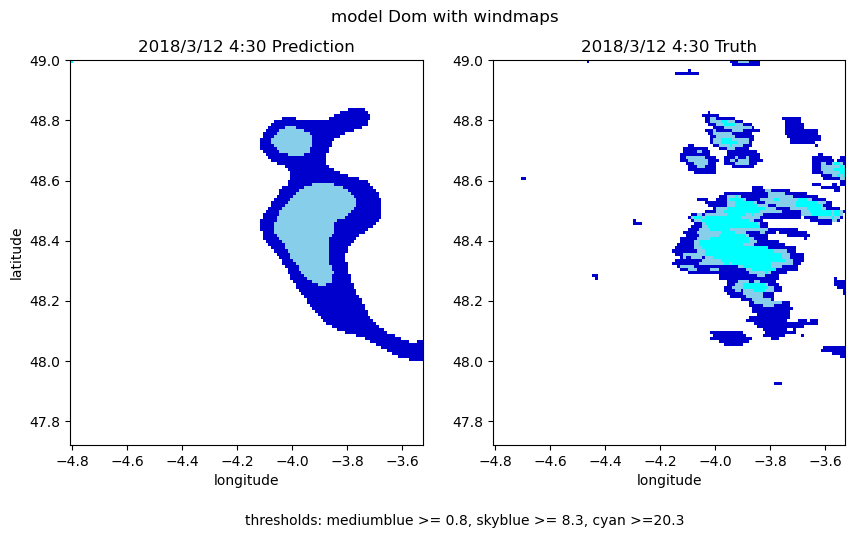

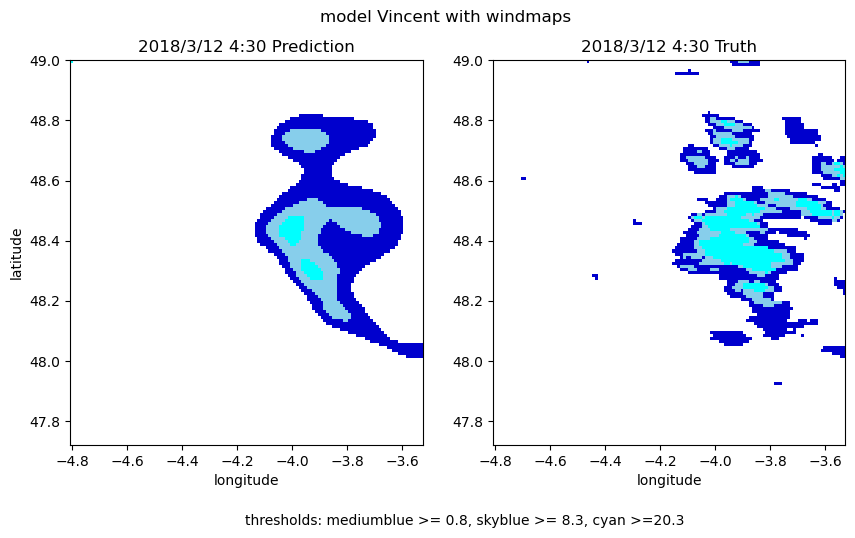

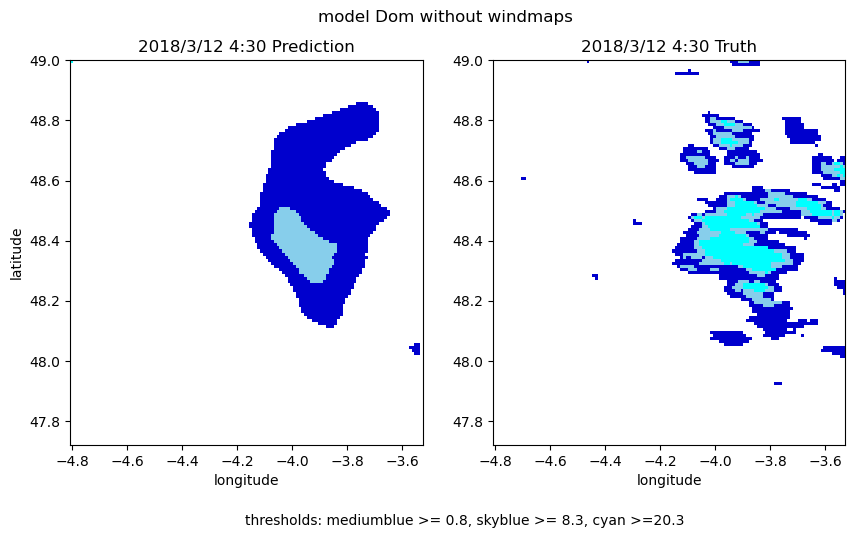

In [8]:
from loader.plots import plot_inference

plot_inference( val_ds, val_date, model_dom.to('cpu'), thresholds, lon, lat, zone, 'model Dom with windmaps')
plot_inference( val_ds, val_date, model_vinc.to('cpu'), thresholds, lon, lat, zone, 'model Vincent with windmaps')
plot_inference( rain_val_ds, val_date, model_dom_rain.to('cpu'), thresholds, lon, lat, zone, 'model Dom without windmaps')


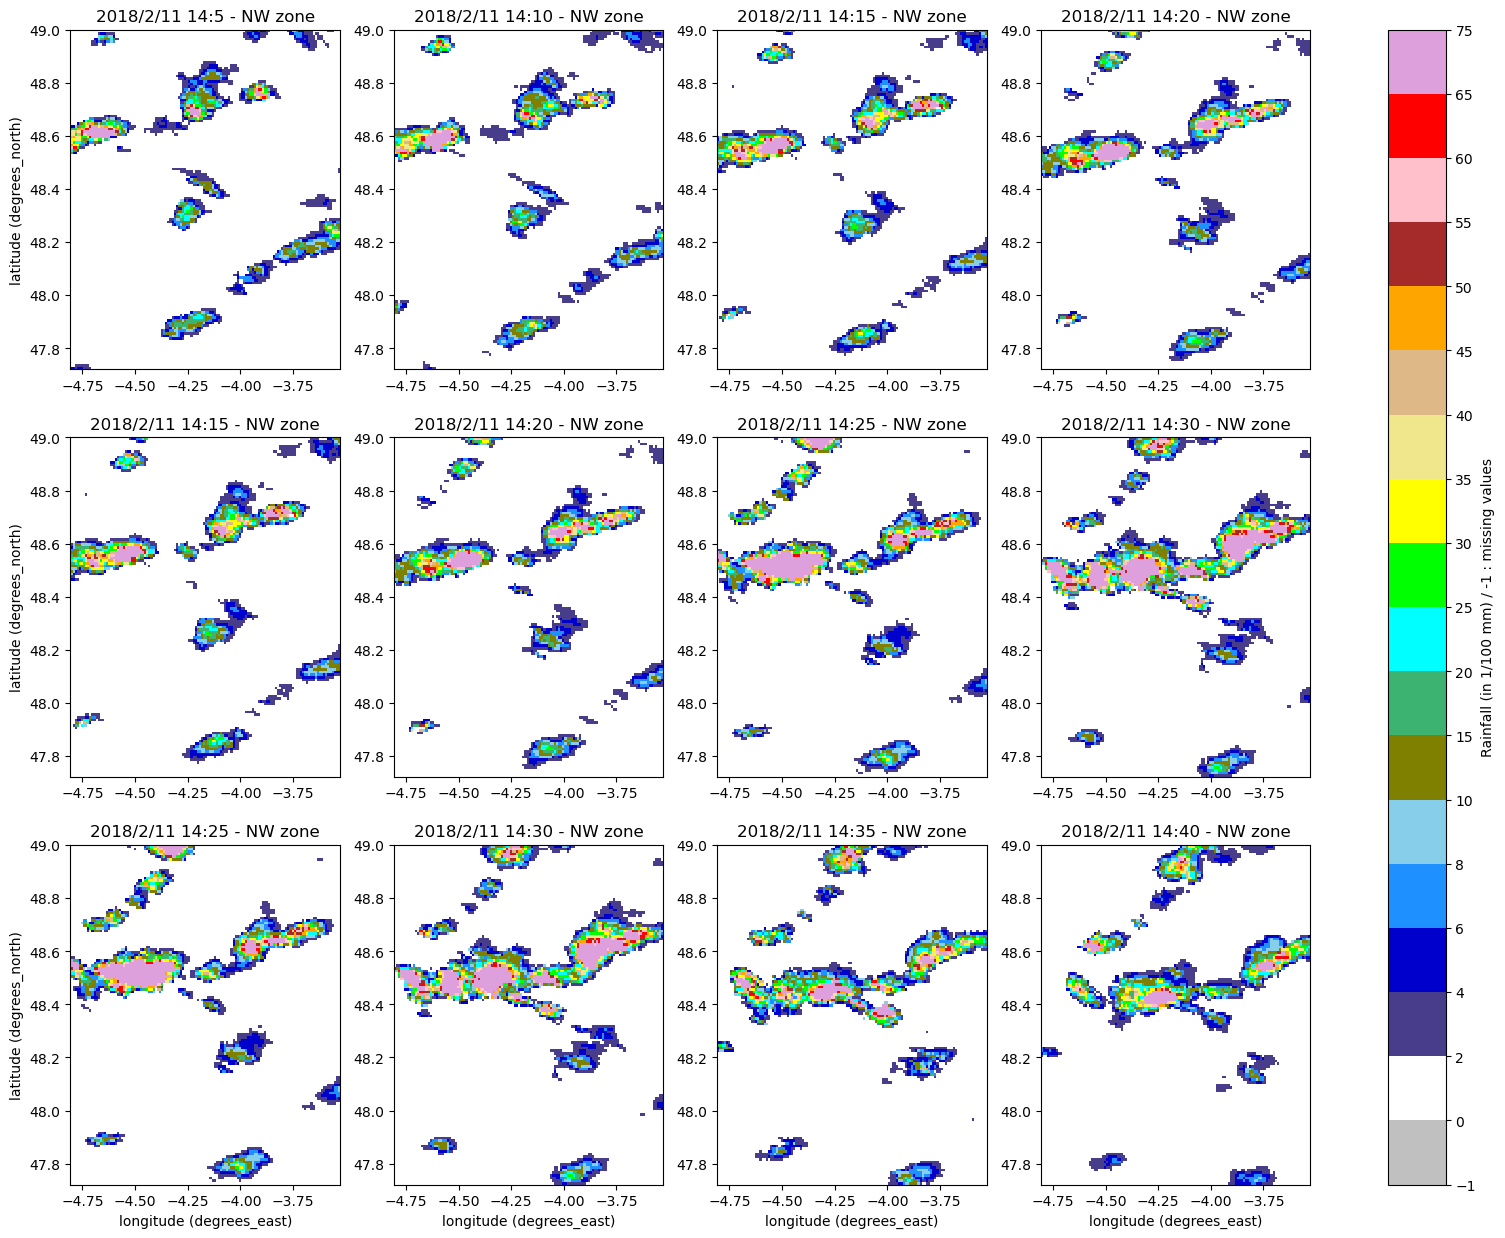

In [9]:
test_date = 2018, 2, 11, 14, 5
plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone, n=4)

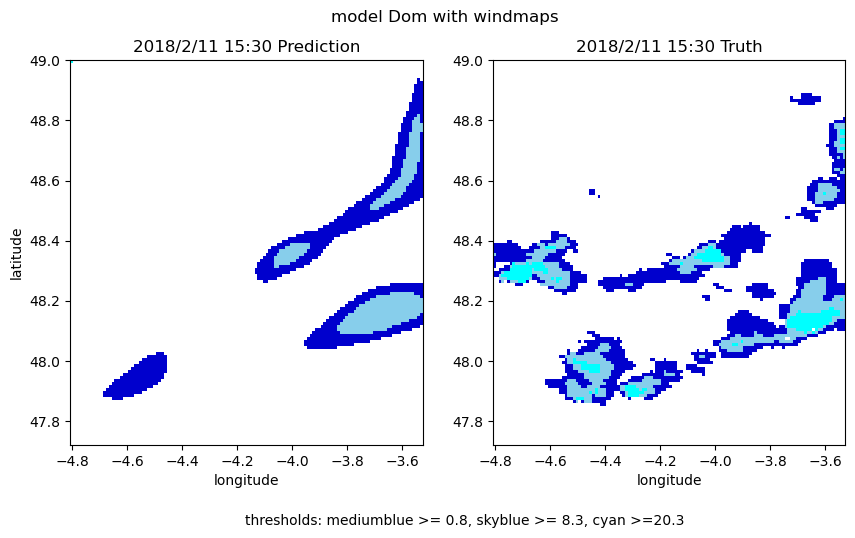

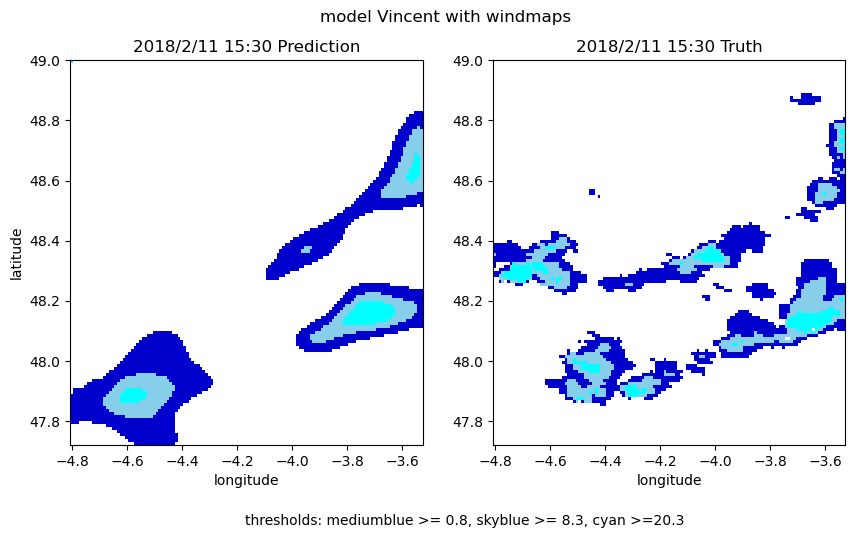

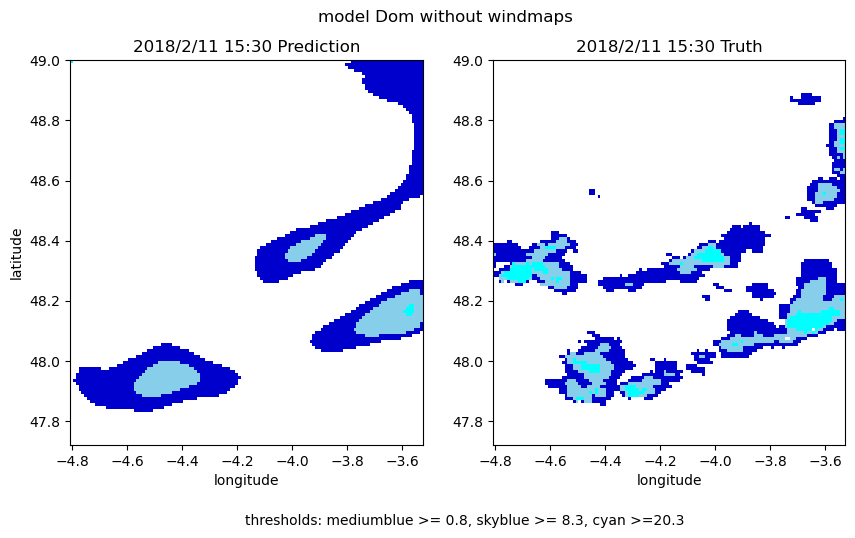

In [11]:
plot_inference( test_ds, test_date, model_dom.to('cpu'), thresholds, lon, lat, zone, 'model Dom with windmaps')
plot_inference( test_ds, test_date, model_vinc.to('cpu'), thresholds, lon, lat, zone, 'model Vincent with windmaps')
plot_inference( rain_test_ds, test_date, model_dom_rain.to('cpu'), thresholds, lon, lat, zone, 'model Dom without windmaps')

torch.Size([1, 36, 128, 128])


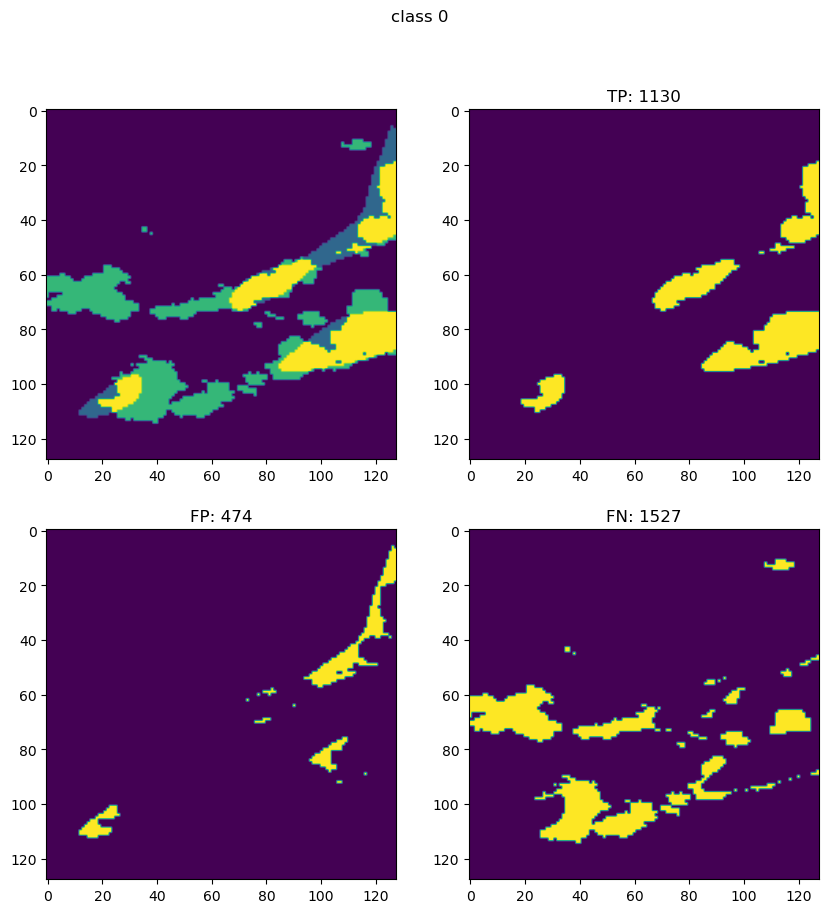

In [11]:
from loader.plots import plot_TPFPFN
plot_TPFPFN( test_ds, test_date, model_dom.to('cpu'), thresholds, 0)

# evaluation on test set

In [12]:
from tqdm import tqdm
from loader.utilities import calculate_TP_TN_FP_FN, calculate_scores, map_to_classes
import pandas as pd

device = torch.device('mps')

def get_xy( data):
    return data['inputs'], map_to_classes(data['target'], thresholds)

def eval_test( dl, model, device):
    TPFPFN = 0
    model.to(device)
    model.eval()
    for data in tqdm(dl):
        x,y = get_xy(data)
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(x)
        TPFPFN += calculate_TP_TN_FP_FN(torch.sigmoid(y_hat)>.5, y)
    return TPFPFN.cpu()

## Scores

$$
\begin{pmatrix}
TP = hits & FP = false\ alarms \\
FN = misses & TN = correct\ negatives 
\end{pmatrix}
$$


| Name | Def | Meaning | Used by | Alternative names |
| ----------- | ----------- | ----------- | ------ | ----- |
| Precision | $\frac{TP}{TP+FN}$ |  | [1,2] | POD [1] | 
| Recall | $\frac{TP}{TP+FP}$  |   | [1,3] | Success Ratio [3] | 
| $F_1$ | $2\frac{Prec\times Recall}{Prec+Recall}$ | Harmonic mean of prec/recall| [1] |
| Threat Score (TS) | $\frac{TP}{TP+FP+FN}$ | | [1,2,3] | Critical Success Index (CSI) |
| Bias | $\frac{Recall}{Prec}$ |  under (<1) or over (>1) estimate | [1,3] |
| False Alarm Rate (FAR) | $\frac{FP}{FP+TN}$ | | [1,2,3] |  Probability of False Detection (POFD) [3] |
| Heidke Skill Score (HSS)$^*$ | $\frac{2(TP\times TN - FP\times FN)}{(TP+FN)(FN+TN)+(TP+FP)(FP+TN)}$ | fraction of correct detection after removing random chance | [3]|
| Accuracy | $\frac{TP+TN}{TP+TN+FP+FN}$ | fraction of correct detection | [3] |
| Equitable Threat Score (ETS)$^{**}$ | $\frac{TP-TP_{random}}{TP+FP+FN-TP_{random}}$ | TS corrected of random chance|  [3] |  
| Odds Ratio Skill Score (ORSS) | $\frac{TP\times TN - FP\times FN}{TP\times TN + FP\times FN}$ | improvement of forecast over random chance|  [3] |


$^*$ The HSS formulation used here is an alternative definition due to Hogan, 2009. \
$^{**}$ $TP_{random} = \frac{(TP+FN)(TP+FP)}{TP+TN+FP+FN} $ 


[1] Bouget et al, 2021 \
[2] Zebiri et al, 2019 \
[3] Kumar et al, 2020: An embedded convolutional LSTM-based architecture for precipitation nowcasting using satellite data. PLoS ONE 15(3)

In [13]:
dom_stats = eval_test( test_loader, model_dom, device)

  0%|                                                                                                                                                                            | 0/61 [00:00<?, ?it/s]/Users/bereziat/opt/miniconda/envs/torch/lib/python3.11/site-packages/torch/nn/functional.py:3959: UserWarning: MPS: passing scale factor to upsample ops is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/aten/src/ATen/native/mps/operations/UpSample.mm:233.)
  return torch._C._nn.upsample_bilinear2d(input, output_size, align_corners, scale_factors)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [01:39<00:00,  1.64s/it]


In [14]:
pd.DataFrame( dom_stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,2699811,801389,199729
TN,58583618,61368164,62484629
FP,851893,424939,149744
FN,1024998,565828,326218


In [22]:
score_names = ['Pres/POD','Recall/Success Ratio','F1','TS/CSI','Bias','HSS','FAR','Accuracy', 'ETS', 'ORSS']
pd.DataFrame( calculate_scores( dom_stats), columns=['C1','C2','C3'], index=score_names)

,C1,C2,C3
Pres/POD,0.760145,0.653487,0.571515
Recall/Success Ratio,0.724819,0.586146,0.379751
F1,0.742062,0.617987,0.456304
TS/CSI,0.589903,0.447165,0.295592
Bias,0.953526,0.896952,0.664464
HSS,0.726305,0.610004,0.452668
FAR,0.014333,0.006877,0.002391
Accuracy,0.970284,0.984313,0.992464
ETS,0.570235,0.438853,0.292545
ORSS,0.989019,0.990269,0.992202


In [16]:
dom_rain_stats = eval_test( rain_test_loader, model_dom_rain, device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:27<00:00,  2.50it/s]


In [17]:
pd.DataFrame( dom_rain_stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,3430263,910909,183514
TN,64656366,68418267,69834349
FP,1168984,453553,133540
FN,1375811,848695,480021


In [23]:
pd.DataFrame( calculate_scores( dom_rain_stats), columns=['C1','C2','C3'], index=score_names)

,C1,C2,C3
Pres/POD,0.745831,0.667596,0.578810
Recall/Success Ratio,0.713735,0.517678,0.276570
F1,0.729430,0.583156,0.374293
TS/CSI,0.574097,0.411588,0.230234
Bias,0.956966,0.775437,0.477826
HSS,0.710141,0.573884,0.370470
FAR,0.017759,0.006585,0.001909
Accuracy,0.963971,0.981563,0.991313
ETS,0.550557,0.402410,0.227347
ORSS,0.985601,0.987723,0.990046


In [19]:
vinc_stats = eval_test( test_loader, model_vinc, device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [01:16<00:00,  1.26s/it]


In [20]:
pd.DataFrame( vinc_stats, columns=['C1','C2','C3'], index=['TP','TN','FP','FN'])

,C1,C2,C3
TP,2587120,726468,198723
TN,58612311,61377896,62437482
FP,823200,415207,196891
FN,1137689,640749,327224


In [24]:
pd.DataFrame( calculate_scores( vinc_stats), columns=['C1','C2','C3'], index=score_names)

,C1,C2,C3
Pres/POD,0.758615,0.636318,0.502315
Recall/Success Ratio,0.694564,0.531348,0.377838
F1,0.725178,0.579115,0.431275
TS/CSI,0.568847,0.407573,0.274921
Bias,0.915569,0.835036,0.752194
HSS,0.708760,0.570656,0.427178
FAR,0.013850,0.006719,0.003143
Accuracy,0.968954,0.983281,0.991702
ETS,0.548898,0.399244,0.271601
ORSS,0.987723,0.988138,0.989669
